In [ ]:
#Sample OTFS using symbol DNN and finding SER

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# --- OTFS Parameters ---
N, M = 4, 4  # Size of DD grid
mod_order = 4  # QPSK (|A| = 4)
num_symbols = N * M  # Total symbols in DD grid
num_train = 10000  # Number of training samples
num_test = 2000  # Number of test samples

# --- Generate QPSK Modulation Alphabet ---
qpsk_symbols = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2)
symbol_map = {i: qpsk_symbols[i] for i in range(len(qpsk_symbols))}

# --- Function to Generate Random OTFS Data ---
def generate_otfs_data(num_samples):
    x = np.random.randint(0, mod_order, (num_samples, num_symbols))
    x_modulated = np.array([symbol_map[i] for i in x.flatten()]).reshape(num_samples, num_symbols)

    # Generate random complex channel matrix H (Rayleigh fading)
    H = (np.random.randn(num_samples, num_symbols, num_symbols) +
         1j * np.random.randn(num_samples, num_symbols, num_symbols)) / np.sqrt(2)

    # Received signal y = Hx + noise
    noise = (np.random.randn(num_samples, num_symbols) +
             1j * np.random.randn(num_samples, num_symbols)) * 0.1  # SNR control
    y = np.einsum('ijk,ik->ij', H, x_modulated) + noise

    return x, y  # Return integer labels and noisy received signal

# Generate Training and Test Data
x_train, y_train = generate_otfs_data(num_train)
x_test, y_test = generate_otfs_data(num_test)

# Convert to real-valued inputs (Concatenate real and imaginary parts)
y_train_real = np.hstack((y_train.real, y_train.imag))
y_test_real = np.hstack((y_test.real, y_test.imag))

# --- Symbol-DNN Model ---
def build_symbol_dnn():
    model = Sequential([
        Input(shape=(2 * num_symbols,)),  # Real and Imaginary parts
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(mod_order, activation='softmax')  # Output |A| neurons
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train MN independent DNNs for each symbol in DD grid
symbol_dnns = [build_symbol_dnn() for _ in range(num_symbols)]

# Train each DNN separately
for i in range(num_symbols):
    print(f"Training Symbol-DNN {i+1}/{num_symbols}")
    symbol_dnns[i].fit(y_train_real, x_train[:, i], epochs=10, batch_size=64, verbose=1)

# --- Testing Phase ---
def detect_symbols(y_input):
    y_input_real = np.hstack((y_input.real, y_input.imag))  # Convert input format
    detected_symbols = np.zeros((y_input.shape[0], num_symbols), dtype=int)

    for i in range(num_symbols):
        probs = symbol_dnns[i].predict(y_input_real, verbose=0)
        detected_symbols[:, i] = np.argmax(probs, axis=1)

    return detected_symbols

# Predict symbols on test set
x_pred = detect_symbols(y_test)

# Compute Symbol Error Rate (SER)
ser = np.mean(x_pred != x_test)
print(f"Symbol Error Rate (SER): {ser:.4f}")


Training Symbol-DNN 1/16
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.2513 - loss: 1.5429
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2852 - loss: 1.3833
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3354 - loss: 1.3466
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3685 - loss: 1.3219
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4044 - loss: 1.2961
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4274 - loss: 1.2719
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4338 - loss: 1.2502
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4703 - loss: 1.2171
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4857 - loss: 1.1916
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4868 - loss: 1.1696
Training Symbol-DNN 2/16
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2557 - loss: 1.5417
Epo

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.6882
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0666
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0146
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0068
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0041
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0027
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0019
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0015
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.5089e-04
Epoch 12/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0497e-04
Epoch 13/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9496e-04
Epoch 14/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.5150e-04
Epoch 15/50
118/118 ━━━━━━━━━━━━━━━━━━━

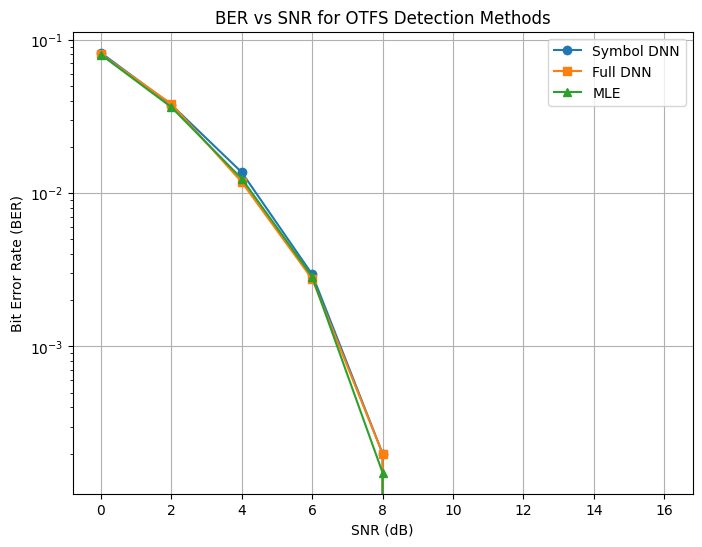

In [ ]:
#BPSK w/o channel, just noise added and demodulated (Symbol DNN, Full DNN, MLE)

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

# --- OTFS Parameters ---
M, N = 2, 2  # Size of DD grid (Total symbols = MN = 4)
mod_order = 2  # BPSK (|A| = 2)
num_symbols = M * N  # Total symbols per frame
num_train = 30000  # Training examples
num_test = 5000  # Testing examples
snr_range = np.arange(0, 18, 2)  # SNR values in dB

# --- BPSK Symbol Mapping ---
bpsk_symbols = np.array([-1, 1])  # BPSK symbols {-1, +1}
symbol_map = {i: bpsk_symbols[i] for i in range(len(bpsk_symbols))}

# Function to generate OTFS symbols
def generate_otfs_symbols(num_samples):
    return np.random.choice(bpsk_symbols, (num_samples, num_symbols))

# Function to add AWGN noise
def add_awgn_noise(symbols, snr_db):
    snr_linear = 10**(snr_db / 10)
    noise_std = np.sqrt(1 / (2 * snr_linear))
    noise = noise_std * np.random.randn(*symbols.shape)
    return symbols + noise

# --- Symbol DNN Model ---
def build_symbol_dnn():
    model = models.Sequential([
        layers.Dense(32, activation='relu', input_shape=(num_symbols,)),
        layers.Dense(16, activation='relu'),
        layers.Dense(num_symbols, activation='tanh')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Train Symbol DNN
symbol_dnn = build_symbol_dnn()
x_train = generate_otfs_symbols(num_train)
y_train = x_train  # Noisy input, clean output
symbol_dnn.fit(add_awgn_noise(x_train, 10), y_train, epochs=50, batch_size=256, verbose=1)

# --- Full DNN Model ---
def build_full_dnn():
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(num_symbols,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_symbols, activation='tanh')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Train Full DNN
full_dnn = build_full_dnn()
x_train = generate_otfs_symbols(num_train)
y_train = x_train  # Learning end-to-end mapping
full_dnn.fit(add_awgn_noise(x_train, 10), y_train, epochs=50, batch_size=256, verbose=1)

# --- Maximum Likelihood Estimation ---
def mle_detection(received):
    possible_symbols = np.array([-1, 1])
    estimated = np.sign(received)
    return estimated

# --- BER Calculation ---
def calculate_ber(method, snr_range):
    ber = []
    for snr in snr_range:
        x_test = generate_otfs_symbols(num_test)
        noisy_x = add_awgn_noise(x_test, snr)

        if method == 'symbol_dnn':
            detected = np.sign(symbol_dnn.predict(noisy_x))
        elif method == 'full_dnn':
            detected = np.sign(full_dnn.predict(noisy_x))
        elif method == 'mle':
            detected = mle_detection(noisy_x)
        else:
            raise ValueError("Invalid method")

        errors = np.sum(detected != x_test)
        ber.append(errors / (num_test * num_symbols))
    return ber

# Compute BER for each method
ber_symbol_dnn = calculate_ber('symbol_dnn', snr_range)
ber_full_dnn = calculate_ber('full_dnn', snr_range)
ber_mle = calculate_ber('mle', snr_range)

# Plot BER vs SNR
plt.figure(figsize=(8, 6))
plt.semilogy(snr_range, ber_symbol_dnn, 'o-', label='Symbol DNN')
plt.semilogy(snr_range, ber_full_dnn, 's-', label='Full DNN')
plt.semilogy(snr_range, ber_mle, '^-', label='MLE')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('BER vs SNR for OTFS Detection Methods')
plt.legend()
plt.grid(True)
plt.show()

Training Symbol-DNN...
Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2106 - loss: 0.6657
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1901 - loss: 0.4066
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1624 - loss: 0.1252
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2106 - loss: 0.0557
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2299 - loss: 0.0391
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2344 - loss: 0.0329
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2197 - loss: 0.0295
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2199 - loss: 0.0266
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2115 - loss: 0.0262
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2101 - loss: 0.0262
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2119 - loss: 0.0246
Epoch 12/50
118/118 ━━━━━━━━━

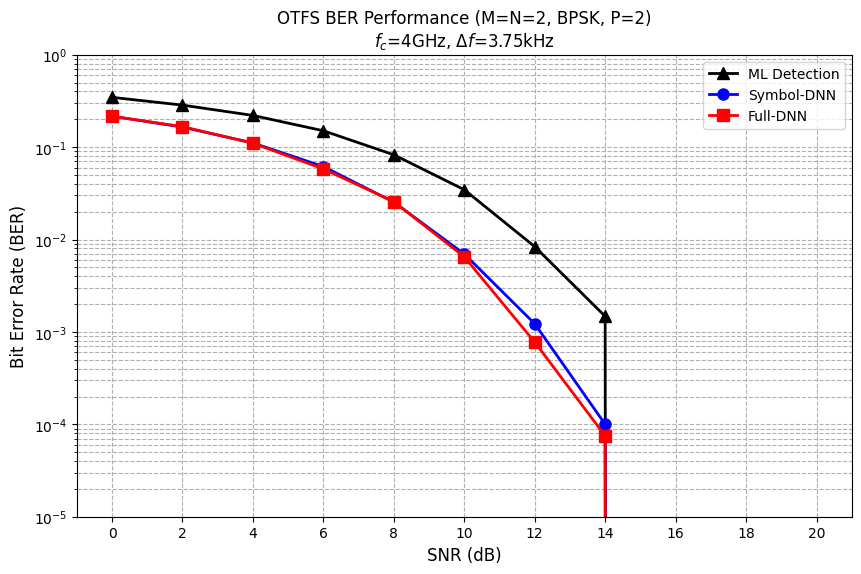

In [ ]:
#BPSK with channel (Symbol DNN, Full DNN, MLE)

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# --- OTFS Parameters ---
M, N = 2, 2
mod_order = 2  # BPSK
num_symbols = M * N
num_train = 30000
num_test = 10000  # Increased for more reliable BER
snr_range = np.linspace(0, 20, 11)  # More SNR points

# Channel parameters
taps = 2
delay_taps = np.array([0, 1])
doppler_taps = np.array([0.1, -0.1])  # Small Doppler shifts
chan_coef = np.array([0.8, 0.6]) * np.exp(1j * np.random.uniform(0, 2*np.pi, taps))  # Complex coefficients
#try different values

# --- Data Generation ---
def generate_otfs_symbols(num_samples):
    return np.random.choice([-1, 1], (num_samples, num_symbols))

def otfs_channel_output(symbols, snr_db):
    snr_linear = 10**(snr_db / 10)
    noise_std = np.sqrt(1 / (2 * snr_linear))

    symbols_grid = symbols.reshape(-1, M, N).astype(np.complex128)
    received_symbols = np.zeros_like(symbols_grid, dtype=np.complex128)

    for i in range(taps):
        delayed_symbols = np.roll(symbols_grid, delay_taps[i], axis=1)
        doppler_phase = np.exp(1j * 2*np.pi*doppler_taps[i]*np.arange(N)/N)
        received_symbols += chan_coef[i] * delayed_symbols * doppler_phase

    noise = noise_std * (np.random.randn(*symbols_grid.shape) + 1j*np.random.randn(*symbols_grid.shape))
    return (received_symbols + noise).real.reshape(-1, num_symbols)

# --- Improved ML Detection ---
def ml_detection(received, snr_db):
    # Generate all possible BPSK combinations
    all_combinations = np.array(np.meshgrid(*[[-1,1]]*num_symbols)).T.reshape(-1,num_symbols)

    # Calculate likelihood for each combination
    likelihoods = []
    for comb in all_combinations:
        # Simulate what would be received for this combination
        simulated = otfs_channel_output(comb[np.newaxis,:], snr_db)
        # Calculate Euclidean distance
        distance = np.sum((received - simulated)**2, axis=1)
        likelihoods.append(distance)

    # Select combination with minimum distance
    detected_idx = np.argmin(likelihoods, axis=0)
    return all_combinations[detected_idx]

# --- DNN Models ---
def build_symbol_dnn():
    model = models.Sequential([
        layers.Dense(32, activation='relu', input_shape=(num_symbols,)),
        layers.Dense(16, activation='relu'),
        layers.Dense(num_symbols*2, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

def build_full_dnn():
    model = models.Sequential([
        layers.Dense(32, activation='relu', input_shape=(num_symbols,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(16, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

# --- Training ---
x_train = generate_otfs_symbols(num_train)
noisy_x_train = otfs_channel_output(x_train, 10)

# Symbol-DNN labels
y_train_symbol = to_categorical(((x_train + 1)//2).flatten(), 2).reshape(-1, num_symbols*2)

# Full-DNN labels
binary_labels = ((x_train + 1)//2).astype(int)
y_train_full = np.sum(binary_labels * (2**np.arange(num_symbols-1, -1, -1)), axis=1)
y_train_full = to_categorical(y_train_full, 16)

# Train models
print("Training Symbol-DNN...")
symbol_dnn = build_symbol_dnn()
symbol_dnn.fit(noisy_x_train, y_train_symbol, epochs=50, batch_size=256, verbose=1)

print("\nTraining Full-DNN...")
full_dnn = build_full_dnn()
full_dnn.fit(noisy_x_train, y_train_full, epochs=50, batch_size=256, verbose=1)

# --- BER Calculation ---
def calculate_ber(method):
    ber = []
    for snr in snr_range:
        x_test = generate_otfs_symbols(num_test)
        noisy_x = otfs_channel_output(x_test, snr)

        if method == 'mle':
            detected = np.zeros_like(x_test)
            for i in range(0, num_test, 100):  # Process in batches to avoid memory issues
                detected[i:i+100] = ml_detection(noisy_x[i:i+100], snr)
        elif method == 'symbol_dnn':
            preds = symbol_dnn.predict(noisy_x, verbose=0)
            detected = (np.argmax(preds.reshape(-1, num_symbols, 2), axis=2) * 2 - 1)
        elif method == 'full_dnn':
            preds = full_dnn.predict(noisy_x, verbose=0)
            detected_bits = (np.argmax(preds, axis=1)[:,None] & (2**np.arange(num_symbols-1,-1,-1))) != 0
            detected = detected_bits * 2 - 1

        errors = np.sum(detected != x_test)
        ber.append(errors / (num_test * num_symbols))
    return ber

# Calculate BER
print("\nCalculating BER...")
ber_mle = calculate_ber('mle')
ber_symbol = calculate_ber('symbol_dnn')
ber_full = calculate_ber('full_dnn')

# --- Plotting ---
plt.figure(figsize=(10,6))
plt.semilogy(snr_range, ber_mle, 'k^-', label='ML Detection', linewidth=2, markersize=8)
plt.semilogy(snr_range, ber_symbol, 'bo-', label='Symbol-DNN', linewidth=2, markersize=8)
plt.semilogy(snr_range, ber_full, 'rs-', label='Full-DNN', linewidth=2, markersize=8)

plt.xlabel('SNR (dB)', fontsize=12)
plt.ylabel('Bit Error Rate (BER)', fontsize=12)
plt.title('OTFS BER Performance (M=N=2, BPSK, P=2)\n$f_c$=4GHz, $\Delta f$=3.75kHz', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, which="both", ls="--")
plt.xticks(np.arange(0, 21, 2))
plt.ylim(1e-5, 1)
plt.show()

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7679
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1546
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0447
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0188
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0119
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0085
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035
Epoch 12/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034
Epoch 13/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028
Epoch 14/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026
Epoch 15/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

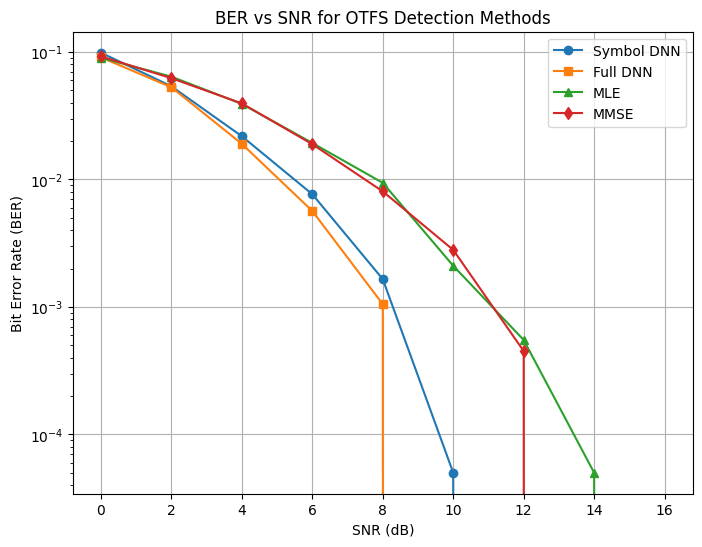

In [ ]:
#Improved BPSK with channel (More Realistic BPSK system) (Symbol DNN, Full DNN, MLE, MMSE)

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from scipy.linalg import toeplitz

# --- OTFS Parameters ---
M, N = 2, 2  # Size of DD grid (Total symbols = MN = 4)
mod_order = 2  # BPSK (|A| = 2)
num_symbols = M * N  # Total symbols per frame
num_train = 30000  # Training examples
num_test = 5000  # Testing examples
snr_range = np.arange(0, 18, 2)  # SNR values in dB

# --- BPSK Symbol Mapping ---
bpsk_symbols = np.array([-1, 1])  # BPSK symbols {-1, +1}

# Function to generate OTFS symbols
def generate_otfs_symbols(num_samples):
    return np.random.choice(bpsk_symbols, (num_samples, num_symbols))

# --- OTFS Channel Implementation ---
taps = 2
delay_taps = np.array([0, 1])  # Two-tap channel with delays at 0 and 1
doppler_taps = np.array([0, 0])  # No Doppler shift
channel_coeffs = np.array([1+0j, 1+0j])  # Constant channel coefficients

# Function to construct a correct Toeplitz channel matrix
def construct_correct_channel_matrix():
    first_col = np.zeros(num_symbols, dtype=np.complex128)
    first_col[delay_taps] = channel_coeffs  # Fill with delay tap coefficients
    H_toeplitz = toeplitz(first_col, np.zeros(num_symbols, dtype=np.complex128))
    return H_toeplitz

# Generate the correct channel matrix
H = construct_correct_channel_matrix()
H_inv = np.linalg.pinv(H)  # Compute pseudo-inverse for MLE

# Function to apply OTFS channel
def apply_otfs_channel(symbols):
    return np.dot(symbols, H.T).real  # Apply channel effect and return real part for BPSK

# Function to add AWGN noise
def add_awgn_noise(symbols, snr_db):
    snr_linear = 10**(snr_db / 10)
    noise_std = np.sqrt(1 / (2 * snr_linear))
    noise = noise_std * np.random.randn(*symbols.shape)
    return symbols + noise

# --- Symbol DNN Model ---
def build_symbol_dnn():
    model = models.Sequential([
        layers.Dense(32, activation='relu', input_shape=(num_symbols,)),
        layers.Dense(16, activation='relu'),
        layers.Dense(num_symbols, activation='tanh')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Train Symbol DNN
symbol_dnn = build_symbol_dnn()
x_train = generate_otfs_symbols(num_train)
y_train = x_train  # Training on clean symbols
x_train_noisy = add_awgn_noise(apply_otfs_channel(x_train), 10)
symbol_dnn.fit(x_train_noisy, y_train, epochs=50, batch_size=256, verbose=1)

# --- Full DNN Model ---
def build_full_dnn():
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(num_symbols,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_symbols, activation='tanh')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Train Full DNN
full_dnn = build_full_dnn()
x_train = generate_otfs_symbols(num_train)
y_train = x_train  # Learning end-to-end mapping
x_train_noisy = add_awgn_noise(apply_otfs_channel(x_train), 10)
full_dnn.fit(x_train_noisy, y_train, epochs=50, batch_size=256, verbose=1)

# --- Improved MLE Detection with Adaptive Regularization ---
def improved_mle_detection(received, snr_db):
    """Perform robust MLE detection using adaptive regularization"""
    snr_linear = 10**(snr_db / 10)  # Convert SNR from dB to linear scale
    regularization_factor = 1 / (2 * snr_linear + 1e-6)  # Adaptive regularization based on SNR

    # Compute regularized least squares estimate
    H_pseudo_inv = np.linalg.inv(H.T @ H + regularization_factor * np.eye(num_symbols)) @ H.T
    x_est = H_pseudo_inv @ received.T  # Apply pseudo-inverse
    return np.sign(x_est.real).T  # Decision based on real part (BPSK)



def calculate_ber(method, snr_range):
    ber = []
    for snr in snr_range:
        x_test = generate_otfs_symbols(num_test)
        noisy_x = add_awgn_noise(apply_otfs_channel(x_test), snr)

        if method == 'symbol_dnn':
            detected = np.sign(symbol_dnn.predict(noisy_x))
        elif method == 'full_dnn':
            detected = np.sign(full_dnn.predict(noisy_x))
        elif method == 'mle':
            detected = improved_mle_detection(noisy_x, snr)
        else:
            raise ValueError("Invalid method")

        errors = np.sum(detected != x_test)
        ber.append(errors / (num_test * num_symbols))
    return ber


# Compute BER for each method
ber_symbol_dnn = calculate_ber('symbol_dnn', snr_range)
ber_full_dnn = calculate_ber('full_dnn', snr_range)
ber_mle = calculate_ber('mle', snr_range)

# --- MMSE Detection ---
# --- MMSE Detection (Fixed) ---
def mmse_detection(received, snr_db):
    """Perform MMSE detection with proper noise variance handling"""
    snr_linear = 10**(snr_db / 10)  # Convert SNR from dB to linear scale
    noise_var = 1 / (2 * snr_linear)  # Proper noise variance for BPSK

    # Compute MMSE filter
    W_mmse = np.linalg.inv(H.conj().T @ H + noise_var * np.eye(num_symbols)) @ H.conj().T

    # Apply MMSE equalization
    x_est = W_mmse @ received.T
    return np.sign(x_est.real).T  # Decision based on real part (BPSK)

# Compute BER for MMSE detection
ber_mmse = []

for snr in snr_range:
    x_test = generate_otfs_symbols(num_test)  # Generate test symbols
    noisy_x = add_awgn_noise(apply_otfs_channel(x_test), snr)  # Transmit through channel
    detected = mmse_detection(noisy_x, snr)  # MMSE detection
    errors = np.sum(detected != x_test)  # Count errors
    ber_mmse.append(errors / (num_test * num_symbols))  # Compute BER

# Plot BER vs SNR
plt.figure(figsize=(8, 6))
plt.semilogy(snr_range, ber_symbol_dnn, 'o-', label='Symbol DNN')
plt.semilogy(snr_range, ber_full_dnn, 's-', label='Full DNN')
plt.semilogy(snr_range, ber_mle, '^-', label='MLE')
plt.semilogy(snr_range, ber_mmse, 'd-', label='MMSE')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('BER vs SNR for OTFS Detection Methods')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3901
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1491
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0932
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0706
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0530
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0468
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0442
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0421
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0405
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0395
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0380
Epoch 12/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0367
Epoch 13/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0356
Epoch 14/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0346
Epoch 15/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

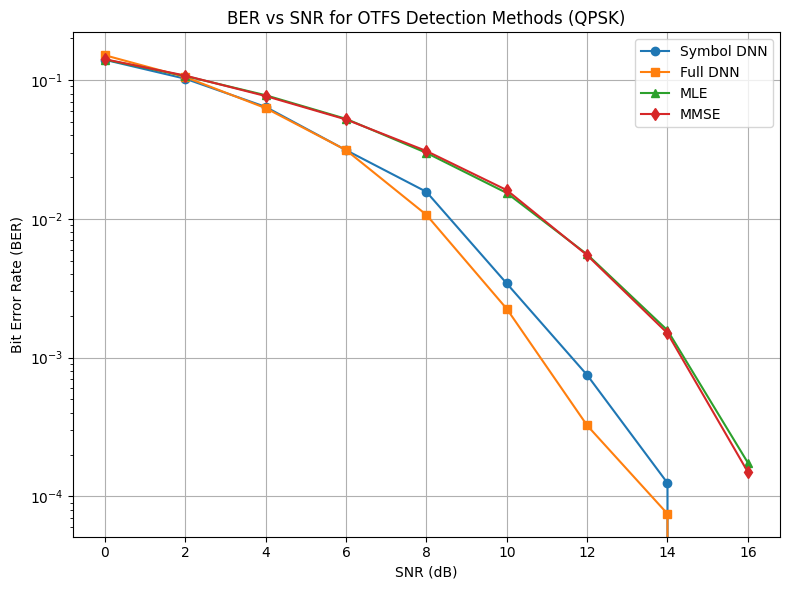

In [ ]:
#Improved QPSK with channel (Symbol DNN, Full DNN, MLE, MMSE)

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from scipy.linalg import toeplitz

# --- Parameters ---
M, N = 2, 2  # DD grid size
num_symbols = M * N
num_train = 30000
num_test = 5000
snr_range = np.arange(0, 18, 2)

# --- QPSK Mapping ---
qpsk_symbols = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2)

def generate_qpsk_symbols(num_samples):
    idx = np.random.randint(0, 4, (num_samples, num_symbols))
    return qpsk_symbols[idx]

# --- OTFS Channel ---
taps = 2
delay_taps = np.array([0, 1])
doppler_taps = np.array([0, 0])  # Static channel (no Doppler)
channel_coeffs = np.array([1+0j, 1+0j])

def construct_channel_matrix():
    first_col = np.zeros(num_symbols, dtype=np.complex128)
    first_col[delay_taps] = channel_coeffs
    return toeplitz(first_col, np.zeros(num_symbols, dtype=np.complex128))

H = construct_channel_matrix()

def apply_otfs_channel(symbols):
    return symbols @ H.T

def add_awgn_noise(symbols, snr_db):
    snr_linear = 10**(snr_db / 10)
    noise_std = np.sqrt(1 / (2 * snr_linear))
    noise = noise_std * (np.random.randn(*symbols.shape) + 1j * np.random.randn(*symbols.shape)) #add noisr std
    return symbols + noise

# --- Symbol DNN ---
def build_symbol_dnn():
    model = models.Sequential([
        layers.Dense(32, activation='relu', input_shape=(2 * num_symbols,)),
        layers.Dense(16, activation='relu'),
        layers.Dense(2 * num_symbols, activation='tanh')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

symbol_dnn = build_symbol_dnn()

# --- Full DNN ---
def build_full_dnn():
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(2 * num_symbols,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(2 * num_symbols, activation='tanh')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

full_dnn = build_full_dnn()

# --- Train Symbol DNN ---
x_train = generate_qpsk_symbols(num_train)
y_train = np.concatenate([x_train.real, x_train.imag], axis=1)
x_train_noisy = apply_otfs_channel(x_train)
x_train_noisy = add_awgn_noise(x_train_noisy, 10)
x_train_noisy = np.concatenate([x_train_noisy.real, x_train_noisy.imag], axis=1)
symbol_dnn.fit(x_train_noisy, y_train, epochs=50, batch_size=256, verbose=1)

# --- Train Full DNN ---
x_train = generate_qpsk_symbols(num_train)
y_train = np.concatenate([x_train.real, x_train.imag], axis=1)
x_train_noisy = apply_otfs_channel(x_train)
x_train_noisy = add_awgn_noise(x_train_noisy, 10)
x_train_noisy = np.concatenate([x_train_noisy.real, x_train_noisy.imag], axis=1)
full_dnn.fit(x_train_noisy, y_train, epochs=50, batch_size=256, verbose=1)

# --- MLE ---
def improved_mle_detection(received, snr_db):
    snr_linear = 10 ** (snr_db / 10)
    reg = 1 / (2 * snr_linear + 1e-6)
    H_pinv = np.linalg.inv(H.T.conj() @ H + reg * np.eye(num_symbols)) @ H.T.conj()
    x_est = H_pinv @ received.T
    return x_est.T

# --- MMSE ---
def mmse_detection(received, snr_db):
    snr_linear = 10**(snr_db / 10)
    noise_var = 1 / (2 * snr_linear)
    W = np.linalg.inv(H.conj().T @ H + noise_var * np.eye(num_symbols)) @ H.conj().T
    x_est = W @ received.T
    return x_est.T

# --- QPSK Nearest Neighbor Detection ---
def qpsk_nearest_neighbor(symbols):
    symbol_array = qpsk_symbols.reshape(1, 1, -1)
    symbols_expanded = np.expand_dims(symbols, axis=2)
    distances = np.abs(symbols_expanded - symbol_array)
    closest_indices = np.argmin(distances, axis=2)
    return qpsk_symbols[closest_indices]

# --- BER ---
def calculate_ber(method, snr_range):
    ber = []
    for snr in snr_range:
        x_test = generate_qpsk_symbols(num_test)
        rx = apply_otfs_channel(x_test)
        rx = add_awgn_noise(rx, snr)

        if method == 'symbol_dnn':
            input_dnn = np.concatenate([rx.real, rx.imag], axis=1)
            pred = symbol_dnn.predict(input_dnn)
            pred_complex = pred[:, :num_symbols] + 1j * pred[:, num_symbols:]
            detected = qpsk_nearest_neighbor(pred_complex)
        elif method == 'full_dnn':
            input_dnn = np.concatenate([rx.real, rx.imag], axis=1)
            pred = full_dnn.predict(input_dnn)
            pred_complex = pred[:, :num_symbols] + 1j * pred[:, num_symbols:]
            detected = qpsk_nearest_neighbor(pred_complex)
        elif method == 'mle':
            pred_complex = improved_mle_detection(rx, snr)
            detected = qpsk_nearest_neighbor(pred_complex)
        elif method == 'mmse':
            pred_complex = mmse_detection(rx, snr)
            detected = qpsk_nearest_neighbor(pred_complex)
        else:
            raise ValueError("Unknown method")

        errors = np.sum(detected != x_test)
        ber.append(errors / (num_test * num_symbols * 2))  # each QPSK symbol has 2 bits
    return ber

# --- Evaluate ---
ber_symbol_dnn = calculate_ber('symbol_dnn', snr_range)
ber_full_dnn = calculate_ber('full_dnn', snr_range)
ber_mle = calculate_ber('mle', snr_range)
ber_mmse = calculate_ber('mmse', snr_range)

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.semilogy(snr_range, ber_symbol_dnn, 'o-', label='Symbol DNN')
plt.semilogy(snr_range, ber_full_dnn, 's-', label='Full DNN')
plt.semilogy(snr_range, ber_mle, '^-', label='MLE')
plt.semilogy(snr_range, ber_mmse, 'd-', label='MMSE')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('BER vs SNR for OTFS Detection Methods (QPSK)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.4866
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1734
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0660
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0396
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0314
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0279
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0265
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0251
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0246
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0243
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0236
Epoch 12/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0232
Epoch 13/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0231
Epoch 14/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0229
Epoch 15/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

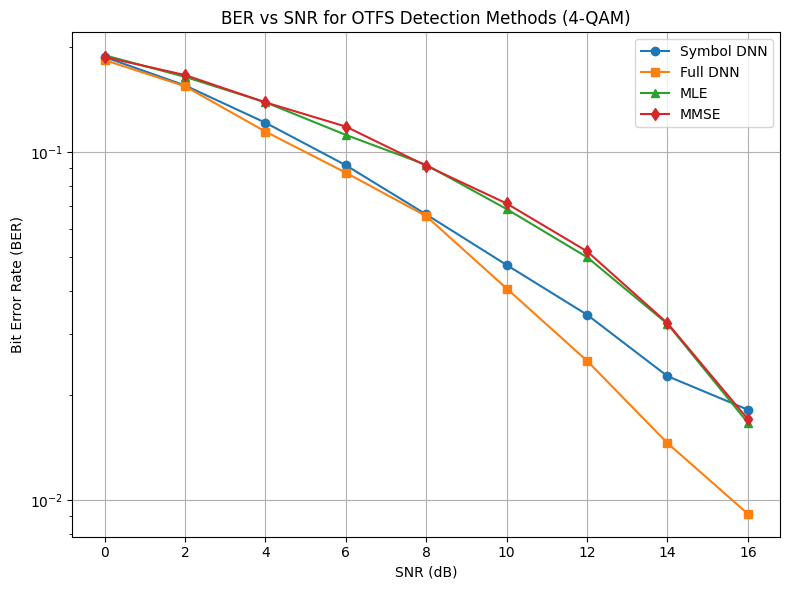

In [ ]:
#QAM with channel (Symbol DNN, Full DNN, MLE, MMSE)

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from scipy.linalg import toeplitz

# --- Parameters ---
M, N = 2, 2  # DD grid size
num_symbols = M * N
num_train = 30000
num_test = 5000
snr_range = np.arange(0, 18, 2)

# --- 4-QAM Mapping (Non-QPSK Like) ---
qam4_symbols = np.array([3+1j, 3-1j, -3+1j, -3-1j]) / np.sqrt(10)

def generate_4qam_symbols(num_samples):
    idx = np.random.randint(0, 4, (num_samples, num_symbols))
    return qam4_symbols[idx]

# --- OTFS Channel ---
taps = 2
delay_taps = np.array([0, 1])
doppler_taps = np.array([0, 0])  # Static channel
channel_coeffs = np.array([1+0j, 1+0j])

def construct_channel_matrix():
    first_col = np.zeros(num_symbols, dtype=np.complex128)
    first_col[delay_taps] = channel_coeffs
    return toeplitz(first_col, np.zeros(num_symbols, dtype=np.complex128))

H = construct_channel_matrix()

def apply_otfs_channel(symbols):
    return symbols @ H.T

def add_awgn_noise(symbols, snr_db):
    snr_linear = 10**(snr_db / 10)
    noise_std = np.sqrt(1 / (2 * snr_linear))
    noise = noise_std * (np.random.randn(*symbols.shape) + 1j * np.random.randn(*symbols.shape))
    return symbols + noise

# --- Symbol DNN ---
def build_symbol_dnn():
    model = models.Sequential([
        layers.Dense(32, activation='relu', input_shape=(2 * num_symbols,)),
        layers.Dense(16, activation='relu'),
        layers.Dense(2 * num_symbols, activation='tanh')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

symbol_dnn = build_symbol_dnn()

# --- Full DNN ---
def build_full_dnn():
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(2 * num_symbols,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(2 * num_symbols, activation='tanh')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

full_dnn = build_full_dnn()

# --- Train Symbol DNN ---
x_train = generate_4qam_symbols(num_train)
y_train = np.concatenate([x_train.real, x_train.imag], axis=1)
x_train_noisy = apply_otfs_channel(x_train)
x_train_noisy = add_awgn_noise(x_train_noisy, 10)
x_train_noisy = np.concatenate([x_train_noisy.real, x_train_noisy.imag], axis=1)
symbol_dnn.fit(x_train_noisy, y_train, epochs=50, batch_size=256, verbose=1)

# --- Train Full DNN ---
x_train = generate_4qam_symbols(num_train)
y_train = np.concatenate([x_train.real, x_train.imag], axis=1)
x_train_noisy = apply_otfs_channel(x_train)
x_train_noisy = add_awgn_noise(x_train_noisy, 10)
x_train_noisy = np.concatenate([x_train_noisy.real, x_train_noisy.imag], axis=1)
full_dnn.fit(x_train_noisy, y_train, epochs=50, batch_size=256, verbose=1)

# --- MLE Detection ---
def improved_mle_detection(received, snr_db):
    snr_linear = 10 ** (snr_db / 10)
    reg = 1 / (2 * snr_linear + 1e-6)
    H_pinv = np.linalg.inv(H.T.conj() @ H + reg * np.eye(num_symbols)) @ H.T.conj()
    x_est = H_pinv @ received.T
    return x_est.T

# --- MMSE Detection ---
def mmse_detection(received, snr_db):
    snr_linear = 10**(snr_db / 10)
    noise_var = 1 / (2 * snr_linear)
    W = np.linalg.inv(H.conj().T @ H + noise_var * np.eye(num_symbols)) @ H.conj().T
    x_est = W @ received.T
    return x_est.T

# --- 4-QAM Nearest Neighbor Detection ---
def qam4_nearest_neighbor(symbols):
    symbol_array = qam4_symbols.reshape(1, 1, -1)
    symbols_expanded = np.expand_dims(symbols, axis=2)
    distances = np.abs(symbols_expanded - symbol_array)
    closest_indices = np.argmin(distances, axis=2)
    return qam4_symbols[closest_indices]

# --- BER Computation ---
def calculate_ber(method, snr_range):
    ber = []
    for snr in snr_range:
        x_test = generate_4qam_symbols(num_test)
        rx = apply_otfs_channel(x_test)
        rx = add_awgn_noise(rx, snr)

        if method == 'symbol_dnn':
            input_dnn = np.concatenate([rx.real, rx.imag], axis=1)
            pred = symbol_dnn.predict(input_dnn, verbose=0)
            pred_complex = pred[:, :num_symbols] + 1j * pred[:, num_symbols:]
            detected = qam4_nearest_neighbor(pred_complex)
        elif method == 'full_dnn':
            input_dnn = np.concatenate([rx.real, rx.imag], axis=1)
            pred = full_dnn.predict(input_dnn, verbose=0)
            pred_complex = pred[:, :num_symbols] + 1j * pred[:, num_symbols:]
            detected = qam4_nearest_neighbor(pred_complex)
        elif method == 'mle':
            pred_complex = improved_mle_detection(rx, snr)
            detected = qam4_nearest_neighbor(pred_complex)
        elif method == 'mmse':
            pred_complex = mmse_detection(rx, snr)
            detected = qam4_nearest_neighbor(pred_complex)
        else:
            raise ValueError("Unknown method")

        errors = np.sum(detected != x_test)
        ber.append(errors / (num_test * num_symbols * 2))  # 2 bits per symbol
    return ber

# --- Evaluate ---
ber_symbol_dnn = calculate_ber('symbol_dnn', snr_range)
ber_full_dnn = calculate_ber('full_dnn', snr_range)
ber_mle = calculate_ber('mle', snr_range)
ber_mmse = calculate_ber('mmse', snr_range)

# --- Plot Results ---
plt.figure(figsize=(8, 6))
plt.semilogy(snr_range, ber_symbol_dnn, 'o-', label='Symbol DNN')
plt.semilogy(snr_range, ber_full_dnn, 's-', label='Full DNN')
plt.semilogy(snr_range, ber_mle, '^-', label='MLE')
plt.semilogy(snr_range, ber_mmse, 'd-', label='MMSE')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('BER vs SNR for OTFS Detection Methods (4-QAM)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.3918
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0944
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0743
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0722
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0713
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0708
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0708
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0699
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0700
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0697
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0696
Epoch 12/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0690
Epoch 13/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0688
Epoch 14/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0689
Epoch 15/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

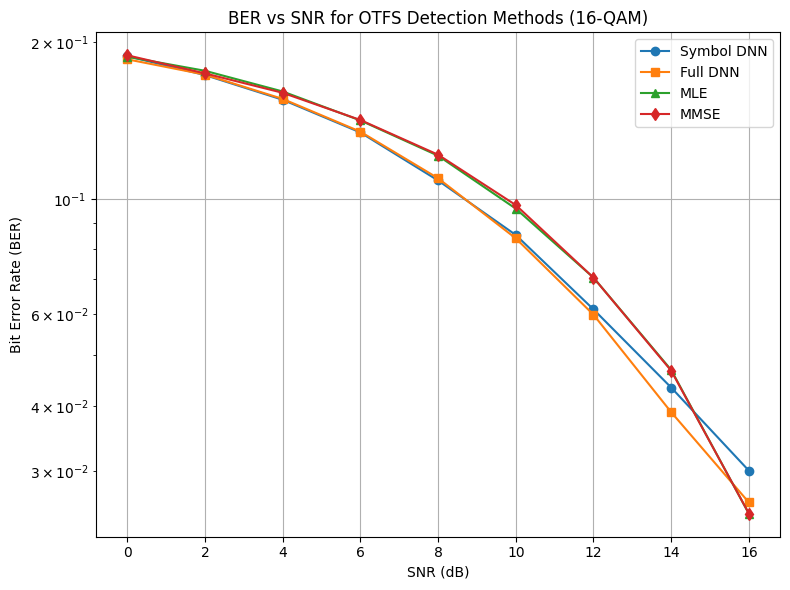

In [ ]:
#16-QPSK with channel (Symbol DNN, Full DNN, MLE, MMSE) (Doppler applied on symbols separately)


import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from scipy.linalg import toeplitz

# --- Parameters ---
M, N = 2, 2  # DD grid size
num_symbols = M * N
num_train = 30000
num_test = 5000
snr_range = np.arange(0, 18, 2)

# --- 16-QAM Mapping ---
re = np.array([-3, -1, 1, 3]) / np.sqrt(10)
im = np.array([-3, -1, 1, 3]) / np.sqrt(10)
qam16_symbols = np.array([x + 1j*y for x in re for y in im])

def generate_16qam_symbols(num_samples):
    idx = np.random.randint(0, 16, (num_samples, num_symbols))
    return qam16_symbols[idx]

# --- OTFS Channel ---
taps = 2
delay_taps = np.array([0, 1])
doppler_taps = np.array([0, 0])  # Static channel (no Doppler)
channel_coeffs = np.array([1+0j, 1+0j])

def construct_channel_matrix():
    first_col = np.zeros(num_symbols, dtype=np.complex128)
    first_col[delay_taps] = channel_coeffs
    return toeplitz(first_col, np.zeros(num_symbols, dtype=np.complex128))

H = construct_channel_matrix()

def apply_otfs_channel(symbols):
    return symbols @ H.T

def add_awgn_noise(symbols, snr_db):
    snr_linear = 10**(snr_db / 10)
    noise_std = np.sqrt(1 / (2 * snr_linear))
    noise = noise_std * (np.random.randn(*symbols.shape) + 1j * np.random.randn(*symbols.shape))
    return symbols + noise

# --- Symbol DNN ---
def build_symbol_dnn():
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(2 * num_symbols,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(2 * num_symbols, activation='tanh')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

symbol_dnn = build_symbol_dnn()

# --- Full DNN ---
def build_full_dnn():
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(2 * num_symbols,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(2 * num_symbols, activation='tanh')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

full_dnn = build_full_dnn()

# --- Train Symbol DNN ---
x_train = generate_16qam_symbols(num_train)
y_train = np.concatenate([x_train.real, x_train.imag], axis=1)
x_train_noisy = apply_otfs_channel(x_train)
x_train_noisy = add_awgn_noise(x_train_noisy, 10)
x_train_noisy = np.concatenate([x_train_noisy.real, x_train_noisy.imag], axis=1)
symbol_dnn.fit(x_train_noisy, y_train, epochs=50, batch_size=256, verbose=1)

# --- Train Full DNN ---
x_train = generate_16qam_symbols(num_train)
y_train = np.concatenate([x_train.real, x_train.imag], axis=1)
x_train_noisy = apply_otfs_channel(x_train)
x_train_noisy = add_awgn_noise(x_train_noisy, 10)
x_train_noisy = np.concatenate([x_train_noisy.real, x_train_noisy.imag], axis=1)
full_dnn.fit(x_train_noisy, y_train, epochs=50, batch_size=256, verbose=1)

# --- MLE ---
def improved_mle_detection(received, snr_db):
    snr_linear = 10 ** (snr_db / 10)
    reg = 1 / (2 * snr_linear + 1e-6)
    H_pinv = np.linalg.inv(H.T.conj() @ H + reg * np.eye(num_symbols)) @ H.T.conj()
    x_est = H_pinv @ received.T
    return x_est.T

# --- MMSE ---
def mmse_detection(received, snr_db):
    snr_linear = 10**(snr_db / 10)
    noise_var = 1 / (2 * snr_linear)
    W = np.linalg.inv(H.conj().T @ H + noise_var * np.eye(num_symbols)) @ H.conj().T
    x_est = W @ received.T
    return x_est.T

# --- 16-QAM Nearest Neighbor Detection ---
def qam16_nearest_neighbor(symbols):
    symbol_array = qam16_symbols.reshape(1, 1, -1)
    symbols_expanded = np.expand_dims(symbols, axis=2)
    distances = np.abs(symbols_expanded - symbol_array)
    closest_indices = np.argmin(distances, axis=2)
    return qam16_symbols[closest_indices]

# --- BER ---
def calculate_ber(method, snr_range):
    ber = []
    for snr in snr_range:
        x_test = generate_16qam_symbols(num_test)
        rx = apply_otfs_channel(x_test)
        rx = add_awgn_noise(rx, snr)

        if method == 'symbol_dnn':
            input_dnn = np.concatenate([rx.real, rx.imag], axis=1)
            pred = symbol_dnn.predict(input_dnn)
            pred_complex = pred[:, :num_symbols] + 1j * pred[:, num_symbols:]
            detected = qam16_nearest_neighbor(pred_complex)
        elif method == 'full_dnn':
            input_dnn = np.concatenate([rx.real, rx.imag], axis=1)
            pred = full_dnn.predict(input_dnn)
            pred_complex = pred[:, :num_symbols] + 1j * pred[:, num_symbols:]
            detected = qam16_nearest_neighbor(pred_complex)
        elif method == 'mle':
            pred_complex = improved_mle_detection(rx, snr)
            detected = qam16_nearest_neighbor(pred_complex)
        elif method == 'mmse':
            pred_complex = mmse_detection(rx, snr)
            detected = qam16_nearest_neighbor(pred_complex)
        else:
            raise ValueError("Unknown method")

        errors = np.sum(detected != x_test)
        ber.append(errors / (num_test * num_symbols * 4))  # 4 bits per 16-QAM symbol
    return ber

# --- Evaluate ---
ber_symbol_dnn = calculate_ber('symbol_dnn', snr_range)
ber_full_dnn = calculate_ber('full_dnn', snr_range)
ber_mle = calculate_ber('mle', snr_range)
ber_mmse = calculate_ber('mmse', snr_range)

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.semilogy(snr_range, ber_symbol_dnn, 'o-', label='Symbol DNN')
plt.semilogy(snr_range, ber_full_dnn, 's-', label='Full DNN')
plt.semilogy(snr_range, ber_mle, '^-', label='MLE')
plt.semilogy(snr_range, ber_mmse, 'd-', label='MMSE')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('BER vs SNR for OTFS Detection Methods (16-QAM)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4131
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0812
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0620
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0599
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0593
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0585
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0583
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0575
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0576
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0578
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0573
Epoch 12/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0573
Epoch 13/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0571
Epoch 14/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0565
Epoch 15/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

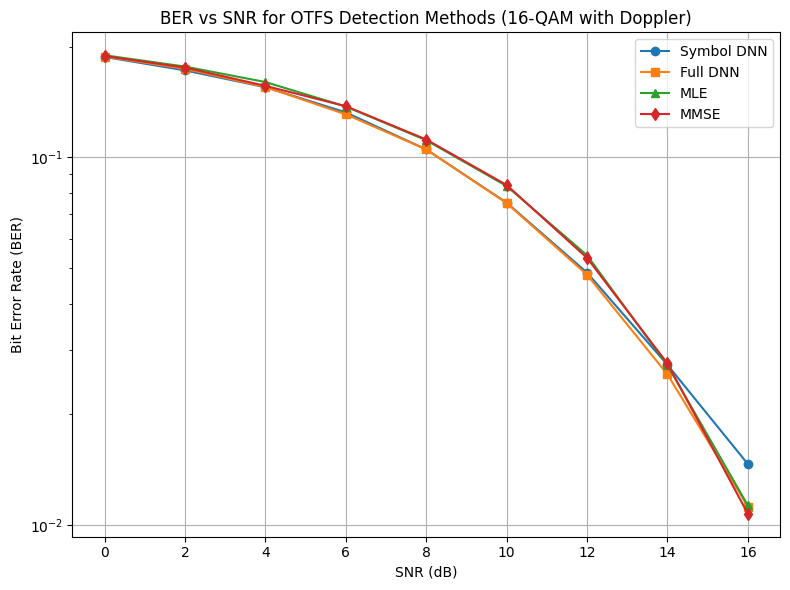

In [ ]:
#16-QPSK with channel (Symbol DNN, Full DNN, MLE, MMSE) (Doppler embedded into channel matrix construction)

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from scipy.linalg import toeplitz

# --- Parameters ---
M, N = 2, 2  # DD grid size
num_symbols = M * N
num_train = 30000
num_test = 5000
snr_range = np.arange(0, 18, 2)

# --- 16-QAM Mapping ---
re = np.array([-3, -1, 1, 3]) / np.sqrt(10)
im = np.array([-3, -1, 1, 3]) / np.sqrt(10)
qam16_symbols = np.array([x + 1j*y for x in re for y in im])

def generate_16qam_symbols(num_samples):
    idx = np.random.randint(0, 16, (num_samples, num_symbols))
    return qam16_symbols[idx]

# --- OTFS Channel with Doppler ---
# Delay and Doppler taps
taps = 2
delay_taps = np.array([0, 1])  # Delay taps
doppler_taps = np.array([0, 1])  # Doppler taps
channel_coeffs = np.array([1+0j, 0.7+0.3j])  # Channel coefficients for the taps

# Doppler shift parameters (simulating user motion)
doppler_shift = np.array([0.1, -0.1])  # Doppler shifts affecting the frequency

def construct_channel_matrix():
    first_col = np.zeros(num_symbols, dtype=np.complex128)
    first_col[delay_taps] = channel_coeffs
    return toeplitz(first_col, np.zeros(num_symbols, dtype=np.complex128))

def apply_doppler_shift(symbols, doppler_shift):
    # Apply Doppler shift to the symbols (frequency shift in time-frequency domain)
    for idx, shift in zip(doppler_taps, doppler_shift):
        symbols[idx] = symbols[idx] * np.exp(1j * 2 * np.pi * shift)  # Apply Doppler shift
    return symbols

# Channel matrix with Doppler
H = construct_channel_matrix()

def apply_otfs_channel(symbols):
    # Apply the channel and Doppler shift
    symbols_with_doppler = apply_doppler_shift(symbols, doppler_shift)
    return symbols_with_doppler @ H.T

def add_awgn_noise(symbols, snr_db):
    snr_linear = 10**(snr_db / 10)
    noise_std = np.sqrt(1 / (2 * snr_linear))
    noise = noise_std * (np.random.randn(*symbols.shape) + 1j * np.random.randn(*symbols.shape))
    return symbols + noise

# --- Symbol DNN ---
def build_symbol_dnn():
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(2 * num_symbols,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(2 * num_symbols, activation='tanh')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

symbol_dnn = build_symbol_dnn()

# --- Full DNN ---
def build_full_dnn():
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(2 * num_symbols,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(2 * num_symbols, activation='tanh')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

full_dnn = build_full_dnn()

# --- Train Symbol DNN ---
x_train = generate_16qam_symbols(num_train)
y_train = np.concatenate([x_train.real, x_train.imag], axis=1)
x_train_noisy = apply_otfs_channel(x_train)
x_train_noisy = add_awgn_noise(x_train_noisy, 10)
x_train_noisy = np.concatenate([x_train_noisy.real, x_train_noisy.imag], axis=1)
symbol_dnn.fit(x_train_noisy, y_train, epochs=50, batch_size=256, verbose=1)

# --- Train Full DNN ---
x_train = generate_16qam_symbols(num_train)
y_train = np.concatenate([x_train.real, x_train.imag], axis=1)
x_train_noisy = apply_otfs_channel(x_train)
x_train_noisy = add_awgn_noise(x_train_noisy, 10)
x_train_noisy = np.concatenate([x_train_noisy.real, x_train_noisy.imag], axis=1)
full_dnn.fit(x_train_noisy, y_train, epochs=50, batch_size=256, verbose=1)

# --- MLE ---
def improved_mle_detection(received, snr_db):
    snr_linear = 10 ** (snr_db / 10)
    reg = 1 / (2 * snr_linear + 1e-6)
    H_pinv = np.linalg.inv(H.T.conj() @ H + reg * np.eye(num_symbols)) @ H.T.conj()
    x_est = H_pinv @ received.T
    return x_est.T

# --- MMSE ---
def mmse_detection(received, snr_db):
    snr_linear = 10**(snr_db / 10)
    noise_var = 1 / (2 * snr_linear)
    W = np.linalg.inv(H.conj().T @ H + noise_var * np.eye(num_symbols)) @ H.conj().T
    x_est = W @ received.T
    return x_est.T

# --- 16-QAM Nearest Neighbor Detection ---
def qam16_nearest_neighbor(symbols):
    symbol_array = qam16_symbols.reshape(1, 1, -1)
    symbols_expanded = np.expand_dims(symbols, axis=2)
    distances = np.abs(symbols_expanded - symbol_array)
    closest_indices = np.argmin(distances, axis=2)
    return qam16_symbols[closest_indices]

# --- BER ---
def calculate_ber(method, snr_range):
    ber = []
    for snr in snr_range:
        x_test = generate_16qam_symbols(num_test)
        rx = apply_otfs_channel(x_test)
        rx = add_awgn_noise(rx, snr)

        if method == 'symbol_dnn':
            input_dnn = np.concatenate([rx.real, rx.imag], axis=1)
            pred = symbol_dnn.predict(input_dnn)
            pred_complex = pred[:, :num_symbols] + 1j * pred[:, num_symbols:]
            detected = qam16_nearest_neighbor(pred_complex)
        elif method == 'full_dnn':
            input_dnn = np.concatenate([rx.real, rx.imag], axis=1)
            pred = full_dnn.predict(input_dnn)
            pred_complex = pred[:, :num_symbols] + 1j * pred[:, num_symbols:]
            detected = qam16_nearest_neighbor(pred_complex)
        elif method == 'mle':
            pred_complex = improved_mle_detection(rx, snr)
            detected = qam16_nearest_neighbor(pred_complex)
        elif method == 'mmse':
            pred_complex = mmse_detection(rx, snr)
            detected = qam16_nearest_neighbor(pred_complex)
        else:
            raise ValueError("Unknown method")

        errors = np.sum(detected != x_test)
        ber.append(errors / (num_test * num_symbols * 4))  # 4 bits per 16-QAM symbol
    return ber

# --- Evaluate ---
ber_symbol_dnn = calculate_ber('symbol_dnn', snr_range)
ber_full_dnn = calculate_ber('full_dnn', snr_range)
ber_mle = calculate_ber('mle', snr_range)
ber_mmse = calculate_ber('mmse', snr_range)

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.semilogy(snr_range, ber_symbol_dnn, 'o-', label='Symbol DNN')
plt.semilogy(snr_range, ber_full_dnn, 's-', label='Full DNN')
plt.semilogy(snr_range, ber_mle, '^-', label='MLE')
plt.semilogy(snr_range, ber_mmse, 'd-', label='MMSE')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('BER vs SNR for OTFS Detection Methods (16-QAM with Doppler)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
